# Environment

In [16]:
import pandas as pd
import yaml
import os
import sys
import importlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
EXO_NSC_COLOR = "#201cf4"  # dark Blue
EXO_NEU_COLOR = "#f04c3c"  # dark Red
ENDO_NSC_COLOR = "#c0dce4"  # light Blue
ENDO_NEU_COLOR = "#f0b4b4"  # light Red
NSC_COLOR = "#201cf4"  # Blue
NEU_COLOR = "#f04c3c"  # Red

# Load config
# CONFIG_PATH = "/home/michal/Github/SRF_MeCP2_CUTandTAG/iterative_alternative/code7_cpg_enrichment/config.yaml"
WORKING_DIR = "D:/Github/SRF_MeCP2_cut_tag/iterative_alternative/code7_cpg_enrichment"
CONFIG_PATH = f"{WORKING_DIR}/config.yaml"
# Specify which configuration to use (1-based index)
# Change this to select different configurations
CONFIG_NUMBER = 3

with open(CONFIG_PATH, 'r') as f:
    # Load all documents from the YAML file
    configs = list(yaml.safe_load_all(f))

# Select the specific configuration (subtract 1 because list is 0-based)
config = configs[CONFIG_NUMBER - 1]

# Get values from the selected config
BASE_DIR = config['base_dir']
RUN_NAME = config['run_name']
CELL_TYPE = config['cell_type']
ALIGNMENT_TYPE = config['alignment_type']
PEAKS_TYPE = config['peaks_type']

ENRICHMENT_FILE = f"{BASE_DIR}/results/{ALIGNMENT_TYPE}/cpg_enrichment/{CELL_TYPE}/{PEAKS_TYPE}/{RUN_NAME}/cpg_enrichment_parallel.csv"
print(ENRICHMENT_FILE)

OUTPUT_LISTS_PATH = f"{BASE_DIR}/results/{ALIGNMENT_TYPE}/cpg_enrichment/{CELL_TYPE}/{PEAKS_TYPE}/{RUN_NAME}/lists"
print(OUTPUT_LISTS_PATH)
os.makedirs(OUTPUT_LISTS_PATH, exist_ok=True)

# Set pandas display options to show all columns without wrapping
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)        # Don't wrap wide DataFrames
pd.set_option('display.max_colwidth', None) # Don't truncate column contents

sys.path.append(f"{WORKING_DIR}")
try:
    import functions
    importlib.reload(functions)
    from functions import *
except ModuleNotFoundError:
    print("Warning: Could not import functions module. Make sure functions.py exists in the code7_cpg_enrichment directory.")


D:/Github/SRF_MeCP2_cut_tag/iterative_alternative/results/no_dedup/cpg_enrichment/NSC/broad/cpg_enrichment_1_rep_in_peaks/cpg_enrichment_parallel.csv
D:/Github/SRF_MeCP2_cut_tag/iterative_alternative/results/no_dedup/cpg_enrichment/NSC/broad/cpg_enrichment_1_rep_in_peaks/lists


In [18]:
def plot_enrichment_distribution_mod(df_list, labels, factor=3, title=None, 
                                     colors=None, alpha=0.7, enrichment_lines=[2],
                                     color1="#f04c3c", color2="#201cf4"):
    """
    Create overlaid histograms of enrichment values for regions bound by both Exo and Endo.
    
    Args:
        df_list: List of DataFrames containing enrichment values
        labels: List of labels for each DataFrame
        factor: Factor to multiply IQR by for determining plot range (default=3)
        title: Optional custom title for the plot
        colors: List of colors for each histogram (default: [color1, color2])
        alpha: Transparency value for histograms (default: 0.5)
        enrichment_lines: List of enrichment values at which to draw vertical lines (default: [1])
        color1: Color for NEU data (default: "#f04c3c")
        color2: Color for NSC data (default: "#201cf4")
    """
    plt.figure(figsize=(10, 6))

    # Determine global range based on all data distributions
    all_enrichments = []
    for df in df_list:
        all_enrichments.extend(df['enrichment'])
    
    q1 = np.quantile(all_enrichments, 0.25)
    q3 = np.quantile(all_enrichments, 0.75)
    iqr = q3 - q1
    range_min = max(0, q1 - factor * iqr)  # Don't go below 0 for enrichment
    range_max = q3 + factor * iqr

    if colors is None:
        colors = [color1, color2]  # Assign default colors


    # Plot overlaid histograms
    for i, df in enumerate(df_list):
        plt.hist(df['enrichment'], bins=50, alpha=alpha,
                 label=labels[i], density=False, range=(range_min, range_max), color=colors[i])

    # Add grid for better readability
    plt.grid(True, alpha=0.3)

    # Improve axis labels and title
    plt.xlabel('Enrichment Score', fontsize=12)
    plt.ylabel('Number of Regions', fontsize=12)
    if title is None:
        title = 'Distribution of Enrichment Values\nin Regions Bound by Both Exo and Endo'
    else:
        title = f'Distribution of Enrichment Values\nin Regions Bound by Both Exo and Endo\n{title}'
    plt.title(title, fontsize=14, pad=15)

    # Add vertical lines at specified enrichment values
    for enrichment_val in enrichment_lines:
        plt.axvline(x=enrichment_val, color='red', linestyle='--', linewidth=2,
                    label=f'Enrichment = {enrichment_val}')

    # Set x-axis limits based on the calculated data range
    plt.xlim(range_min, range_max)

    # Add legend with better positioning
    plt.legend(loc='upper right')

    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    plt.show()
    
    return range_min, range_max


In [19]:
def plot_signal_distribution_mod(df_list, labels, signal_type, factor=3, title=None, colors=None, alpha=0.7, percentile=0.85, color1='#2196F3', color2='#FF9800'):
    """
    Create overlaid histograms of signal values for regions bound by both Exo and Endo.
    
    Args:
        df_list: List of DataFrames containing signal values
        labels: List of labels for each DataFrame
        signal_type: 'exo_signal' or 'endo_signal'
        factor: Factor to multiply IQR by for determining plot range (default=3)
        title: Optional custom title for the plot
        colors: List of colors for each histogram (default=None, uses color1 and color2)
        alpha: Transparency value for histograms (default=0.5)
        percentile: Percentile value for vertical lines (default=0.95, i.e., 95th percentile)
        color1: Color for Neu data (default='#2196F3')
        color2: Color for NSC data (default='#FF9800')
    """
    plt.figure(figsize=(10, 6))

    # Determine global range based on all data distributions
    all_signals = []
    for df in df_list:
        all_signals.extend(df[signal_type])
    
    q1 = np.quantile(all_signals, 0.25)
    q3 = np.quantile(all_signals, 0.75)
    iqr = q3 - q1
    range_min = max(0, q1 - factor * iqr)  # Don't go below 0 for signal
    range_max = q3 + factor * iqr

    if colors is None:
        colors = [color1, color2]  # Assign default colors


    # Plot overlaid histograms
    for i, df in enumerate(df_list):
        plt.hist(df[signal_type], bins=50, alpha=alpha,
                 label=labels[i], density=False, range=(range_min, range_max), color=colors[i])

        # Add vertical lines at specified enrichment values
        enrichment_percentile = np.quantile(df[signal_type], percentile)
        plt.axvline(x=enrichment_percentile, color=colors[i], linestyle='--', linewidth=2,
                    label=f'{labels[i]} {percentile*100:.0f}th percentile = {enrichment_percentile:.2f}')

    # Add grid for better readability
    plt.grid(True, alpha=0.3)

    # Improve axis labels and title
    plt.xlabel(f'{signal_type} Score', fontsize=12)
    plt.ylabel('Number of Regions', fontsize=12)
    if title is None:
        title = f'Distribution of {signal_type} Values'
    else:
        title = f'Distribution of {signal_type} Values\n{title}'
    plt.title(title, fontsize=14, pad=15)


    # Set x-axis limits based on the calculated data range
    plt.xlim(range_min, range_max)

    # Add legend with better positioning
    plt.legend(loc='upper right')

    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    plt.show()
    
    return range_min, range_max


# Load Data

In [20]:
# Load the CpG enrichment results
cpg_enrichment_df = pd.read_csv(ENRICHMENT_FILE)

In [21]:
# Display first few rows and basic info
print("DataFrame shape:", cpg_enrichment_df.shape)
print("\nFirst few rows:")
display(cpg_enrichment_df.head())
print("\nColumn names:")
print(cpg_enrichment_df.columns.tolist())

DataFrame shape: (14939, 24)

First few rows:


,chr,start,end,exo_signal,endo_signal,enrichment,pvalue,binding_type,binding_type_by_peaks,significant,exo_replicates_with_signal,endo_replicates_with_signal,exo_replicate_signals,endo_replicate_signals,region_length,cpg_length,cpg_score,cpg_name,exo_replicates_with_peaks,endo_replicates_with_peaks,exo_peak_scores_by_rep,endo_peak_scores_by_rep,region_start,region_end
0,chr1,3531624,3531843,12.768126,30.869522,0.413616,1.0,both,endo_only,False,1,1,"38.30437894050892,0.0,0.0","0.0,92.60856682520647,0.0",416,219,CpG:,611,0,1,NaN,5.10095,3531809,3532225
1,chr1,3670619,3671074,13.804590,6.752549,2.044352,0.4,both,exo_only,False,3,3,"15.986598596795782,22.98503862960536,2.4421313108708085","11.639562692359062,7.888669696550013,0.7294160477812351",1583,455,CpG:,613,1,0,6.06037,NaN,3670396,3671979
2,chr1,3671654,3672156,15.331182,5.965003,2.570188,0.1,both,exo_only,False,3,3,"14.398215172280159,21.305724717144454,10.289605426735111","10.282046731029238,6.968618375914438,0.6443446448871067",1792,502,CpG:,613,2,0,5.54931;6.06037,NaN,3670396,3672188
3,chr1,4491701,4493673,8.716315,10.776053,0.808860,1.0,both,both,False,2,2,"12.917271586025462,0.0,13.231673493104822","0.0,27.234050478654748,5.094107347376206",1360,1972,CpG:,619,2,1,6.0982;5.8282,4.1282,4492093,4493453
4,chr1,4571641,4572075,25.026296,0.076022,329.197490,0.5,both,exo_only,False,3,1,"30.021045078151403,13.556918122386204,31.500924768035347","0.22806640496387434,0.0,0.0",786,434,CpG:,619,3,0,4.35039;6.82732;3.40697,NaN,4571438,4572224



Column names:
['chr', 'start', 'end', 'exo_signal', 'endo_signal', 'enrichment', 'pvalue', 'binding_type', 'binding_type_by_peaks', 'significant', 'exo_replicates_with_signal', 'endo_replicates_with_signal', 'exo_replicate_signals', 'endo_replicate_signals', 'region_length', 'cpg_length', 'cpg_score', 'cpg_name', 'exo_replicates_with_peaks', 'endo_replicates_with_peaks', 'exo_peak_scores_by_rep', 'endo_peak_scores_by_rep', 'region_start', 'region_end']


**Columns explanation:**

1. Signal vs Peaks columns:

- `endo_replicates_with_signal`: Counts how many replicates have a non-zero signal value when measuring the bigWig signal in the region.
- `endo_replicates_with_peaks`: Counts how many replicates have an overlapping peak in the broadPeak files.

So, e.g. it's possible to have `endo_replicates_with_peaks=0` but `endo_replicates_with_signal=2` because:
- Peaks represent regions that passed the peak caller's statistical threshold for significance
- Signal values represent the raw enrichment data before any statistical filtering
- So you can have detectable signal in a region that wasn't strong/consistent enough to be called as a peak

2. Scores vs Signals:

- `endo_peak_scores_by_rep`: Contains the `signalValue` scores from the broadPeak files for each replicate that has a peak overlapping the region. These scores are peak caller-specific enrichment metrics.
- `endo_replicate_signals`: Contains the actual signal values extracted from the bigWig files for each replicate in that region. These are the raw signal values.

`endo_peak_scores_by_rep` is NaN when there are no peaks overlapping the region in any replicate (`endo_replicates_with_peaks=0`). 

**Handling multiple replicates:**

1. For Signals (from bigWig files):
- Each replicate's signal is obtained independently using `get_signal_from_bigwig()`
- The signals are stored as individual values in `endo_replicate_signals` as a comma-separated string
- The final `endo_signal` used for enrichment calculations is the **mean across all replicates**

2. For Peak Scores:
- Peak scores are stored in `endo_peak_scores_by_rep` using a specific format:
  - Scores from different peaks within the same replicate are **comma-separated**
  - Different replicates are **semicolon-separated**
  - If a replicate has no peaks, it's simply not included in the string
- **There's no averaging of peak scores**

For example:
- If replicate 1 has two peaks with scores 5.0 and 6.0, and replicate 2 has one peak with score 4.0, while replicate 3 has no peaks:
  - `endo_peak_scores_by_rep` would be: `"5.0, 6.0; 4.0"`
  - `endo_replicates_with_peaks` would be `2`
  - If all replicates had signals of `2.0`, `3.0`, and `1.0`:
    - `endo_replicate_signals` would be `"2.0, 3.0, 1.0"`
    - `endo_signal` would be `2.0` (the mean)
    - `endo_replicates_with_signal` would be `3`

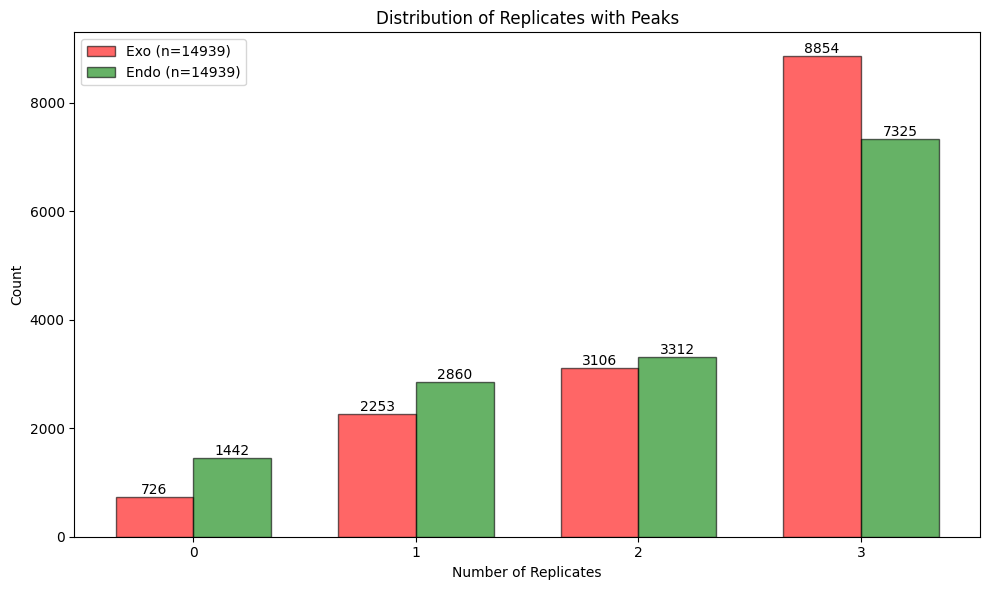

In [22]:
# Create single plot
plt.figure(figsize=(10, 6))

# Get data for plotting
x = np.arange(4)  # 0 through 3 replicates
exo_counts = [len(cpg_enrichment_df[cpg_enrichment_df['exo_replicates_with_peaks'] == i]) for i in range(4)]
endo_counts = [len(cpg_enrichment_df[cpg_enrichment_df['endo_replicates_with_peaks'] == i]) for i in range(4)]

# Plot bars side by side
width = 0.35
plt.bar(x - width/2, exo_counts, width, label=f'Exo (n={sum(exo_counts)})', color='red', alpha=0.6, edgecolor='black')
plt.bar(x + width/2, endo_counts, width, label=f'Endo (n={sum(endo_counts)})', color='green', alpha=0.6, edgecolor='black')

# Add value labels on top of each bar
for i in range(len(x)):
    plt.text(x[i] - width/2, exo_counts[i], str(exo_counts[i]), 
             ha='center', va='bottom')
    plt.text(x[i] + width/2, endo_counts[i], str(endo_counts[i]),
             ha='center', va='bottom')

plt.title('Distribution of Replicates with Peaks')
plt.xlabel('Number of Replicates')
plt.ylabel('Count')
plt.xticks(x)
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
# Sort the DataFrame by enrichment value in descending order
cpg_enrichment_df_sorted = cpg_enrichment_df.sort_values(by='enrichment', ascending=False)

# Split data based on binding type

## By signal value

Non zero signal in minumum 2 replicates

In [24]:
# Split data based on binding type
exo_only_df_by_signal = cpg_enrichment_df_sorted[cpg_enrichment_df_sorted['binding_type'] == 'exo_only']
endo_only_df_by_signal = cpg_enrichment_df_sorted[cpg_enrichment_df_sorted['binding_type'] == 'endo_only'] 
both_df_by_signal = cpg_enrichment_df_sorted[cpg_enrichment_df_sorted['binding_type'] == 'both']

# Print sizes of each group
print(f"Number of CpG islands bound by exo only: {len(exo_only_df_by_signal)}")
print(f"Number of CpG islands bound by endo only: {len(endo_only_df_by_signal)}")
print(f"Number of CpG islands bound by both: {len(both_df_by_signal)}")

nsc_both_df_by_signal = both_df_by_signal
nsc_exo_only_df_by_signal = exo_only_df_by_signal
nsc_endo_only_df_by_signal = endo_only_df_by_signal


Number of CpG islands bound by exo only: 168
Number of CpG islands bound by endo only: 79
Number of CpG islands bound by both: 14692


In [25]:
neu_both_df_by_signal = pd.read_csv(f"{WORKING_DIR}/neu/no_dedup/individual_samples/broad/3_across_peaks_bw_signal_1_rep/both_df_by_signal.csv")
neu_exo_only_df_by_signal = pd.read_csv(f"{WORKING_DIR}/neu/no_dedup/individual_samples/broad/3_across_peaks_bw_signal_1_rep/exo_only_df_by_signal.csv")
neu_endo_only_df_by_signal = pd.read_csv(f"{WORKING_DIR}/neu/no_dedup/individual_samples/broad/3_across_peaks_bw_signal_1_rep/endo_only_df_by_signal.csv")

# Print sizes of each group
print(f"Number of CpG islands bound by exo only: {len(neu_exo_only_df_by_signal)}")
print(f"Number of CpG islands bound by endo only: {len(neu_endo_only_df_by_signal)}")
print(f"Number of CpG islands bound by both: {len(neu_both_df_by_signal)}")

Number of CpG islands bound by exo only: 224
Number of CpG islands bound by endo only: 8
Number of CpG islands bound by both: 14923


## By peaks number

Minimum 2 replicates with peaks

In [26]:
# Split data based on binding type
exo_only_df_by_peaks = cpg_enrichment_df_sorted[cpg_enrichment_df_sorted['binding_type_by_peaks'] == 'exo_only']
endo_only_df_by_peaks = cpg_enrichment_df_sorted[cpg_enrichment_df_sorted['binding_type_by_peaks'] == 'endo_only'] 
both_df_by_peaks = cpg_enrichment_df_sorted[cpg_enrichment_df_sorted['binding_type_by_peaks'] == 'both']

# Print sizes of each group
print(f"Number of CpG islands bound by exo only: {len(exo_only_df_by_peaks)}")
print(f"Number of CpG islands bound by endo only: {len(endo_only_df_by_peaks)}")
print(f"Number of CpG islands bound by both: {len(both_df_by_peaks)}")


Number of CpG islands bound by exo only: 1442
Number of CpG islands bound by endo only: 726
Number of CpG islands bound by both: 12771


# Data analysis

## Enrichment distribution by different signal type

In [27]:
print("Summary statistics of enrichment values selected by signal:")
print(both_df_by_signal['enrichment'].describe())

print("\nSummary statistics of enrichment values selected by peaks:")
print(both_df_by_peaks['enrichment'].describe())

Summary statistics of enrichment values selected by signal:
count    14692.000000
mean         3.020759
std         35.940111
min          0.000184
25%          0.979853
50%          1.376384
75%          1.962012
max       2992.085991
Name: enrichment, dtype: float64

Summary statistics of enrichment values selected by peaks:
count    1.277100e+04
mean              inf
std               NaN
min      0.000000e+00
25%      9.906475e-01
50%      1.353637e+00
75%      1.849448e+00
max               inf
Name: enrichment, dtype: float64


d:\Programs\miniforge3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [28]:
# range_min_signal, range_max_signal = plot_enrichment_distribution(both_df_by_signal, title=None, color=NSC_COLOR, alpha=1.0, enrichment_lines=[2])
# range_min_peaks, range_max_peaks = plot_enrichment_distribution(both_df_by_peaks, title="selected by peaks", color='#2196F3', alpha=1.0, enrichment_lines=[1])


## Compare NEU with NSC - Exo vs Endo Enrichement

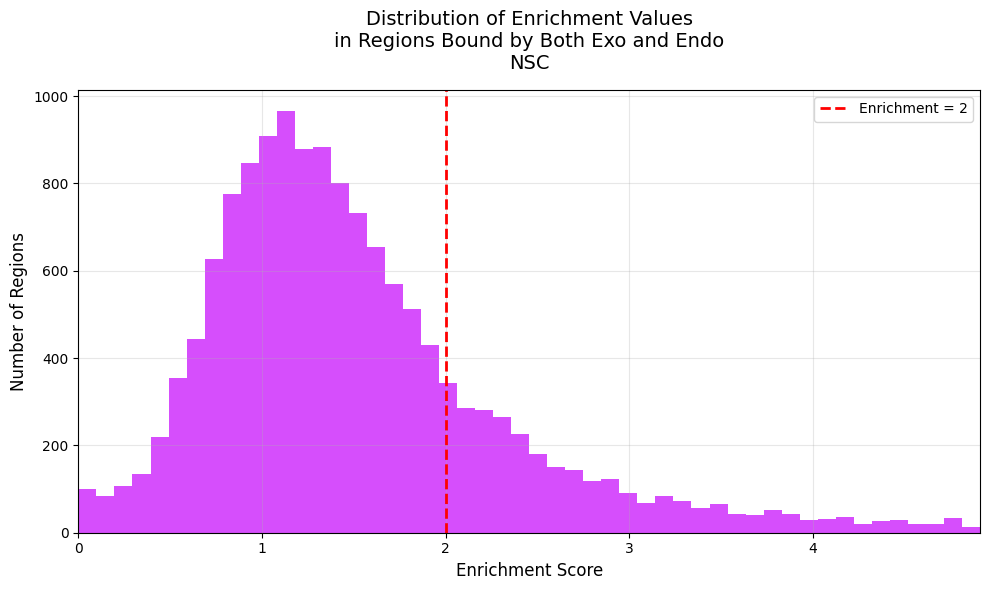

In [34]:
range_min_signal, range_max_signal = plot_enrichment_distribution(nsc_both_df_by_signal, title="NSC", color="#C503FB", alpha=0.7, enrichment_lines=[2])

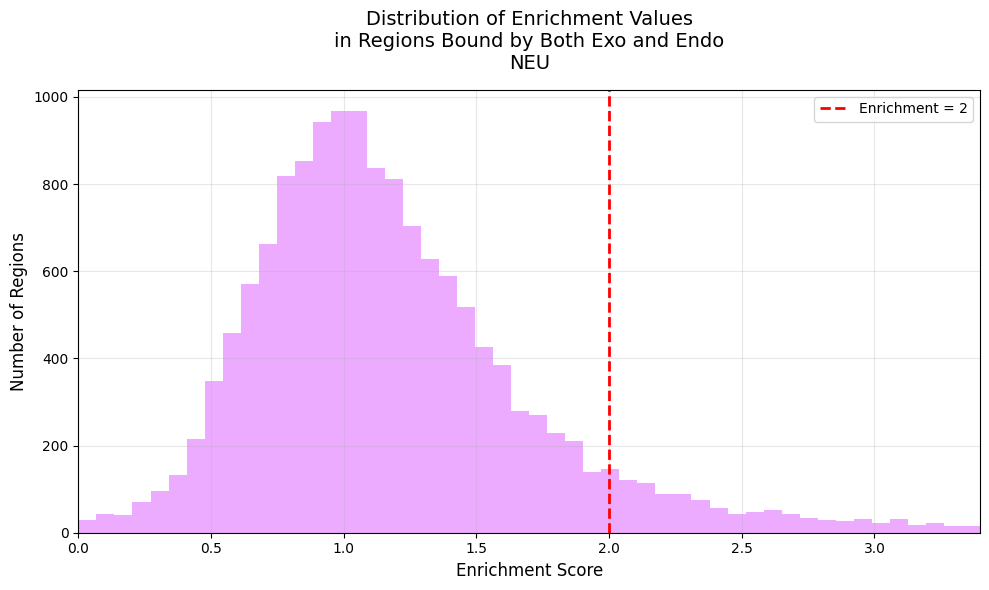

In [35]:
range_min_signal, range_max_signal = plot_enrichment_distribution(neu_both_df_by_signal, title="NEU", color="#E588FF", alpha=0.7, enrichment_lines=[2])

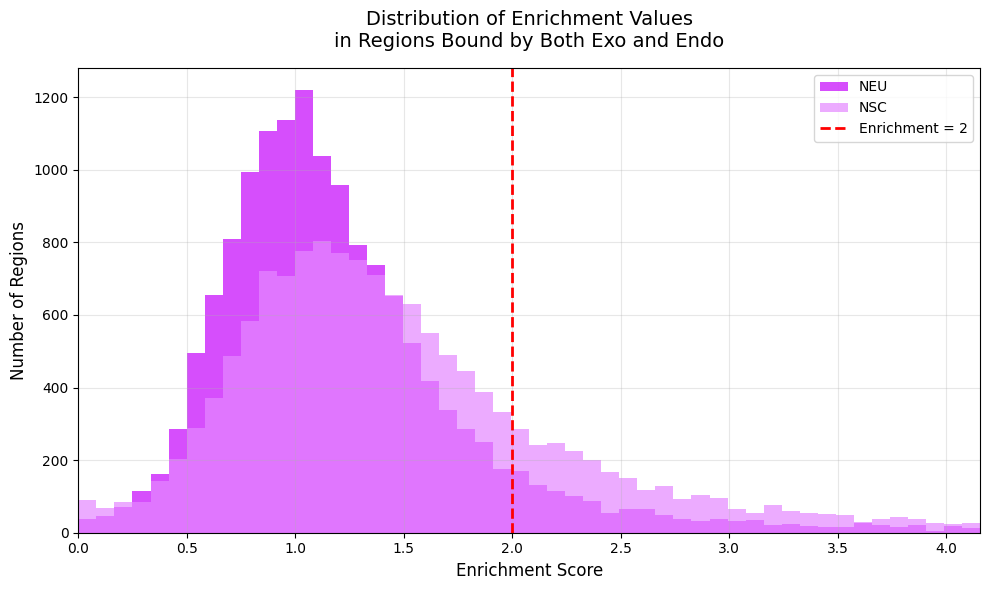

In [33]:
range_min_signal, range_max_signal = plot_enrichment_distribution_mod([neu_both_df_by_signal, nsc_both_df_by_signal], 
                                                                     labels=["NEU", "NSC"], 
                                                                     color1="#C503FB",
                                                                     color2="#E588FF",
                                                                     title=None)

## Compare NEU with NSC - Signal

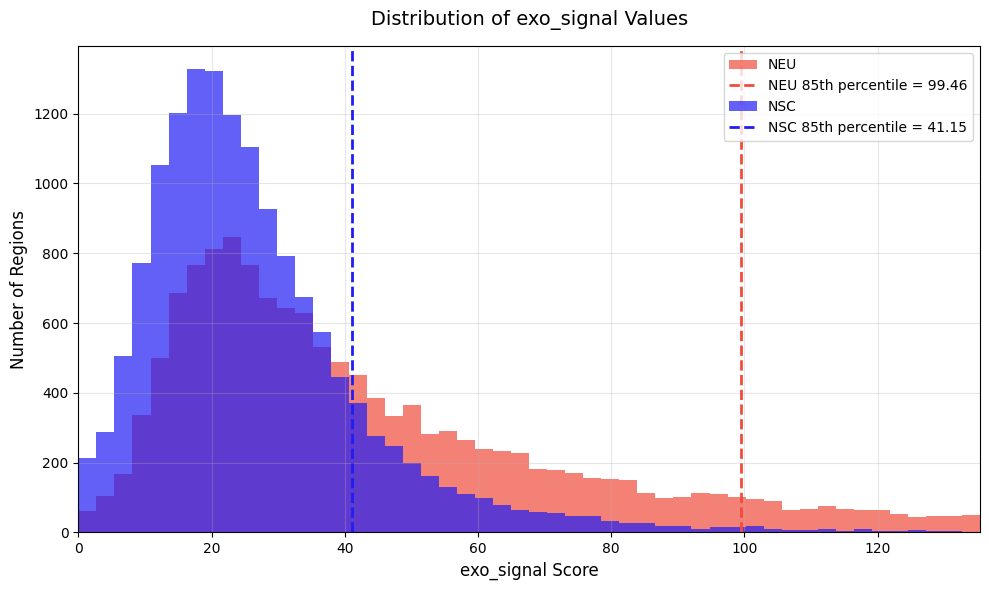

In [134]:

range_min_signal, range_max_signal = plot_signal_distribution_mod([neu_both_df_by_signal, nsc_both_df_by_signal], labels=["NEU", "NSC"], signal_type='exo_signal', color1=EXO_NEU_COLOR,color2=EXO_NSC_COLOR)

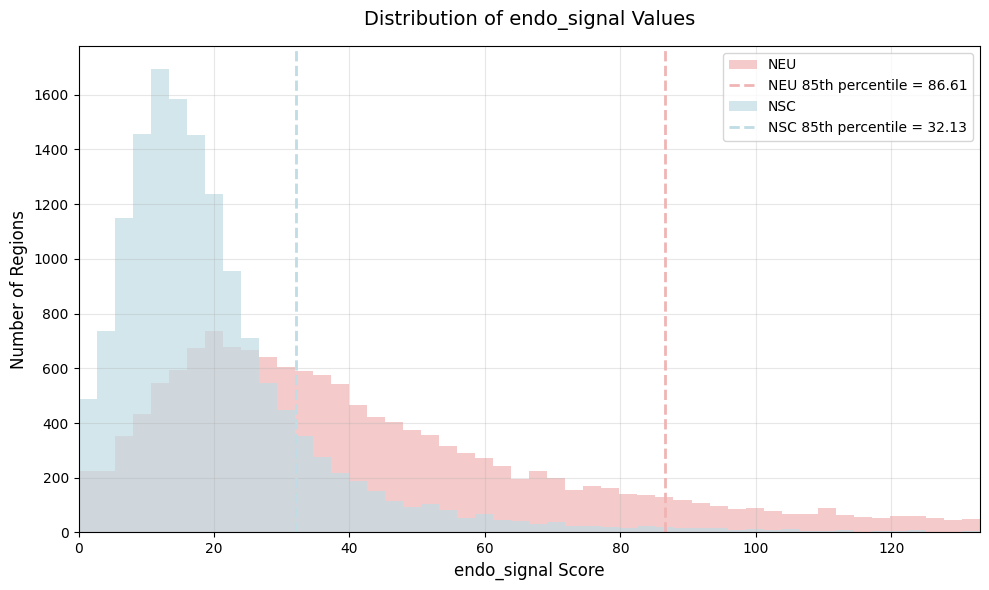

In [135]:
range_min_signal, range_max_signal = plot_signal_distribution_mod([neu_both_df_by_signal, nsc_both_df_by_signal], labels=["NEU", "NSC"], signal_type='endo_signal', color1=ENDO_NEU_COLOR, color2=ENDO_NSC_COLOR)

## Both: enrichment outliers

In [80]:
outliers_df_signal = both_df_by_signal[both_df_by_signal['enrichment'] > range_max_signal].copy()
print(f"\nNumber of outliers selected by signal(enrichment > {range_max_signal}):", len(outliers_df_signal))

outliers_df_peaks = both_df_by_peaks[both_df_by_peaks['enrichment'] > range_max_peaks].copy()
print(f"\nNumber of outliers selected by peaks(enrichment > {range_max_peaks}):", len(outliers_df_peaks))


Number of outliers selected by signal(enrichment > 133.08901983849245): 31

Number of outliers selected by peaks(enrichment > 4.425848887269944): 260


In [81]:
outliers_df_signal.head()

,chr,start,end,exo_signal,endo_signal,enrichment,pvalue,binding_type,binding_type_by_peaks,significant,exo_replicates_with_signal,endo_replicates_with_signal,exo_replicate_signals,endo_replicate_signals,region_length,cpg_length,cpg_score,cpg_name,exo_replicates_with_peaks,endo_replicates_with_peaks,exo_peak_scores_by_rep,endo_peak_scores_by_rep,region_start,region_end
13083,chr8,50915899,50916462,41.620076,0.013910,2992.085991,0.666667,both,exo_only,False,2,1,"21.206400062924338,103.65382761879573,0.0","0.0,0.04173016018337673,0.0",630,563,CpG:,973,1,0,8.11654,NaN,50916048,50916678
14773,chrX,100429023,100429392,13.961147,0.005546,2517.396289,0.666667,both,exo_only,False,2,1,"38.807000222672045,0.0,3.0764408864994803","0.016637603421221156,0.0,0.0",1924,369,CpG:,1351,1,0,4.66669,NaN,100428785,100430709
11810,chr7,15957460,15957815,89.881208,0.079644,1128.534555,0.666667,both,exo_only,False,2,1,"2.263960844021665,0.0,267.3796629837255","0.23893253654954535,0.0,0.0",209,355,CpG:,706,1,0,14.674,NaN,15957487,15957696
6017,chr17,48786309,48786529,13.077180,0.015787,828.354509,0.500000,both,exo_only,False,3,1,"0.18520194389178646,25.856231366942392,13.190107484159885","0.047360810347455866,0.0,0.0",2271,220,CpG:,957,1,0,5.30715,NaN,48785572,48787843
13378,chr8,87038039,87038387,25.390128,0.051017,497.676069,0.666667,both,exo_only,False,2,1,"54.704781578868094,0.0,21.465602649208208","0.0,0.0,0.15305213358224512",389,348,CpG:,1249,2,0,2.91653;7.49339,NaN,87038124,87038513


In [82]:
print_outlier_groups(outliers_df_signal, "signal")


First 5 outliers selected by signal:
chr8:50,915,899-50,916,462                        enrichment: 2992.085990876649
chrX:100,429,023-100,429,392                      enrichment: 2517.3962889240083
chr7:15,957,460-15,957,815                        enrichment: 1128.534555074434
chr17:48,786,309-48,786,529                       enrichment: 828.3545088687762
chr8:87,038,039-87,038,387                        enrichment: 497.6760692273844

Middle 5 outliers selected by signal:
chr4:139,642,009-139,642,236                      enrichment: 231.3283095887521
chr9:114,562,280-114,564,596                      enrichment: 230.70082098527965
chrX:12,140,168-12,140,599                        enrichment: 199.6095810255376
chrX:137,570,910-137,571,192                      enrichment: 183.552072144632
chr7:29,232,164-29,232,722                        enrichment: 182.3739330237301

Last 5 outliers selected by signal:
chr4:65,124,446-65,124,914                        enrichment: 145.5195793968374
chrX:

In [83]:
n_rows = len(outliers_df_signal)

print("\nFirst 5 outliers selected by signal:")
for _, row in outliers_df_signal[:5].iterrows():
    print(f"{row['chr']}:{row['start']:,}-{row['end']:,}".ljust(50) + f"enrichment: {row['enrichment']}")

if n_rows > 10:
    mid_start = n_rows//2 - 2
    print("\nMiddle 5 outliers selected by signal:")
    for _, row in outliers_df_signal[mid_start:mid_start+5].iterrows():
        print(f"{row['chr']}:{row['start']:,}-{row['end']:,}".ljust(50) + f"enrichment: {row['enrichment']}")

print("\nLast 5 outliers selected by signal:")
for _, row in outliers_df_signal[-5:].iterrows():
    print(f"{row['chr']}:{row['start']:,}-{row['end']:,}".ljust(50) + f"enrichment: {row['enrichment']}")


First 5 outliers selected by signal:
chr8:50,915,899-50,916,462                        enrichment: 2992.085990876649
chrX:100,429,023-100,429,392                      enrichment: 2517.3962889240083
chr7:15,957,460-15,957,815                        enrichment: 1128.534555074434
chr17:48,786,309-48,786,529                       enrichment: 828.3545088687762
chr8:87,038,039-87,038,387                        enrichment: 497.6760692273844

Middle 5 outliers selected by signal:
chr4:139,642,009-139,642,236                      enrichment: 231.3283095887521
chr9:114,562,280-114,564,596                      enrichment: 230.70082098527965
chrX:12,140,168-12,140,599                        enrichment: 199.6095810255376
chrX:137,570,910-137,571,192                      enrichment: 183.552072144632
chr7:29,232,164-29,232,722                        enrichment: 182.3739330237301

Last 5 outliers selected by signal:
chr4:65,124,446-65,124,914                        enrichment: 145.5195793968374
chrX:

In [84]:
print_outlier_groups(outliers_df_peaks, "peaks")


First 5 outliers selected by peaks:
chr13:73,846,882-73,847,698                       enrichment: inf
chr15:11,906,067-11,906,438                       enrichment: 31.747233297584664
chr4:129,810,838-129,811,070                      enrichment: 29.9869157902256
chr9:119,894,747-119,895,533                      enrichment: 23.03066985923024
chr2:146,221,265-146,223,848                      enrichment: 20.818379438815622

Middle 5 outliers selected by peaks:
chr9:46,443,405-46,443,903                        enrichment: 5.55351190097038
chrX:158,042,456-158,043,904                      enrichment: 5.550836365541833
chr7:10,495,183-10,495,395                        enrichment: 5.543459086518411
chr13:76,055,567-76,056,709                       enrichment: 5.541599092507944
chr2:104,122,630-104,123,347                      enrichment: 5.531897383039938

Last 5 outliers selected by peaks:
chrX:146,962,658-146,963,233                      enrichment: 4.442287269599509
chr10:33,950,923-33,951

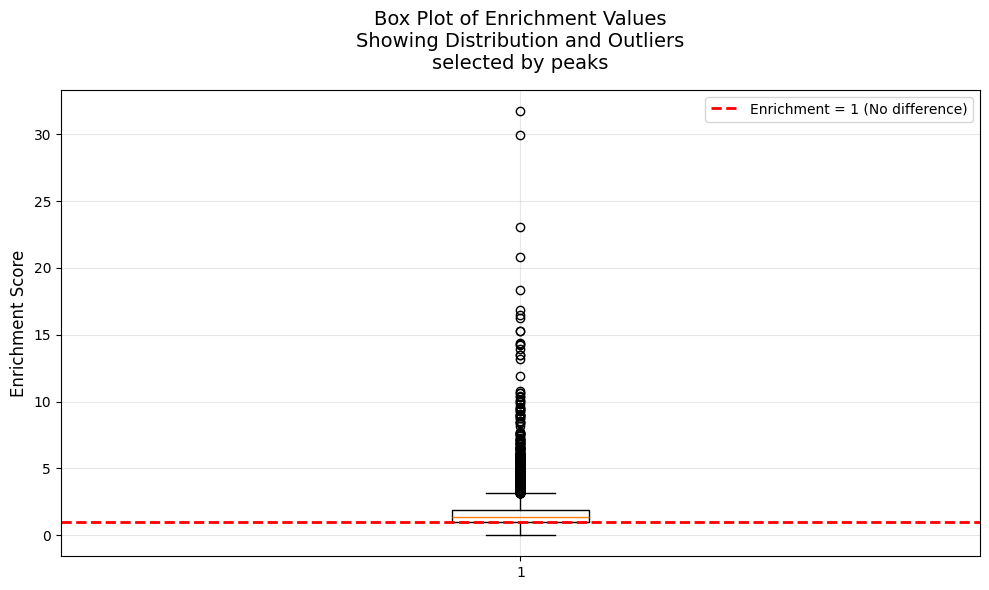

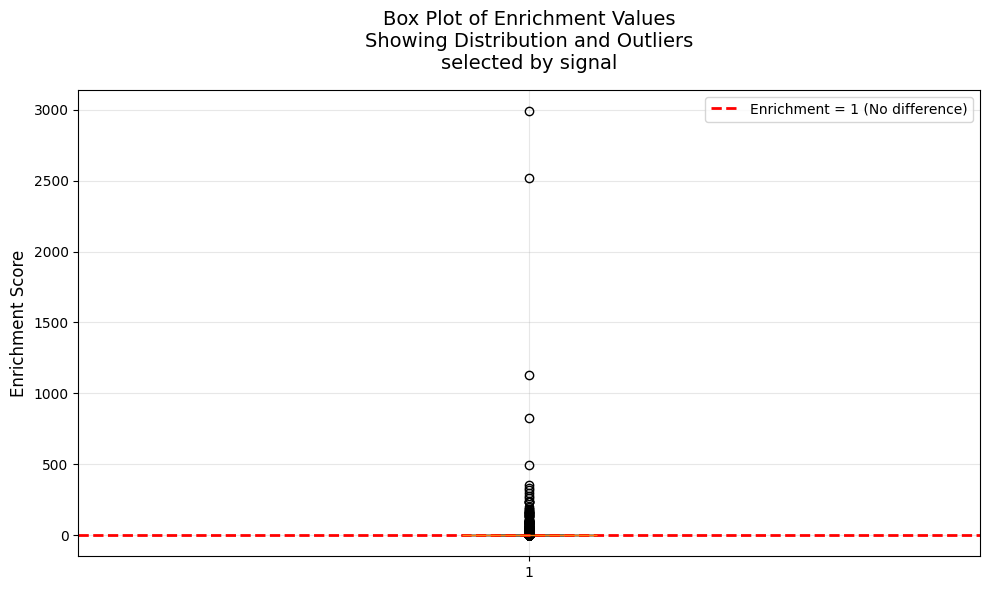

In [85]:
plot_enrichment_boxplot(both_df_by_peaks, title="selected by peaks")
plot_enrichment_boxplot(both_df_by_signal, title="selected by signal")

In [86]:
outliers_df_signal["endo_replicates_with_peaks"].value_counts()

signal_endo_zero_peaks  = outliers_df_signal[outliers_df_signal["endo_replicates_with_peaks"] == 0]
signal_endo_one_peaks   = outliers_df_signal[outliers_df_signal["endo_replicates_with_peaks"] == 1]
signal_endo_two_peaks   = outliers_df_signal[outliers_df_signal["endo_replicates_with_peaks"] == 2]
signal_endo_three_peaks = outliers_df_signal[outliers_df_signal["endo_replicates_with_peaks"] == 3]

outliers_df_peaks["endo_replicates_with_peaks"].value_counts()

peaks_endo_zero_peaks  = outliers_df_peaks[outliers_df_peaks["endo_replicates_with_peaks"] == 0]
peaks_endo_one_peaks   = outliers_df_peaks[outliers_df_peaks["endo_replicates_with_peaks"] == 1]
peaks_endo_two_peaks   = outliers_df_peaks[outliers_df_peaks["endo_replicates_with_peaks"] == 2]
peaks_endo_three_peaks = outliers_df_peaks[outliers_df_peaks["endo_replicates_with_peaks"] == 3]

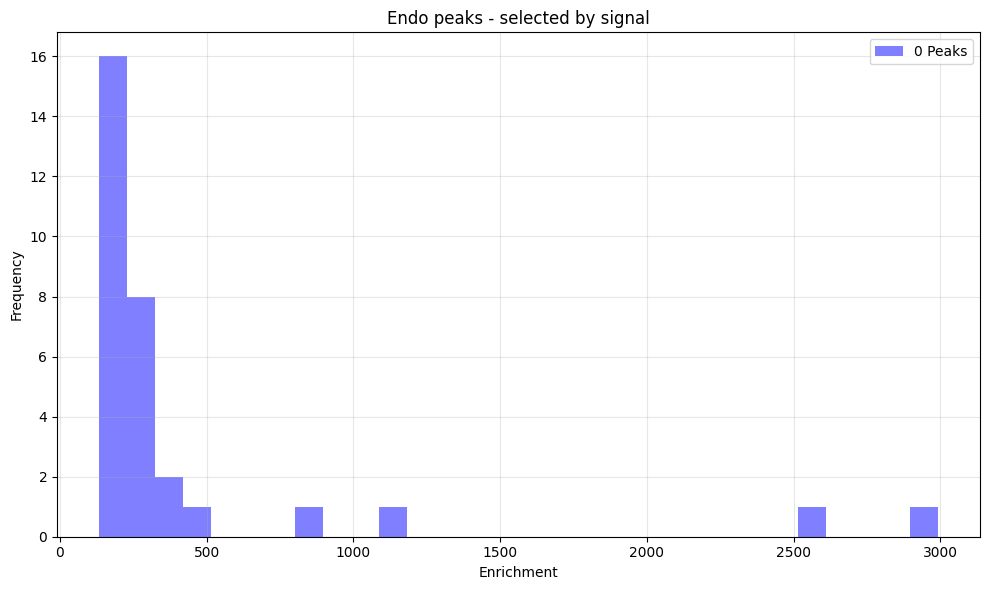

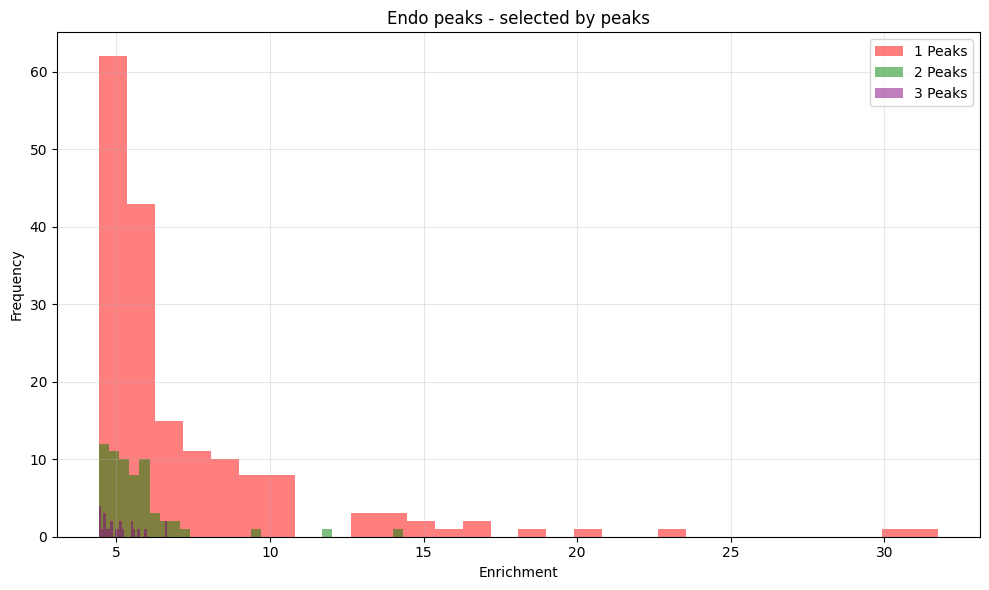

In [87]:
# Classify and plot for signal and peaks outliers
peaks_zero_peaks_signal, peaks_one_peaks_signal, peaks_two_peaks_signal, peaks_three_peaks_signal = plot_by_peaks(outliers_df_signal, peaks_column='endo_replicates_with_peaks', title="Endo peaks - selected by signal")
peaks_zero_peaks_peaks, peaks_one_peaks_peaks, peaks_two_peaks_peaks, peaks_three_peaks_peaks = plot_by_peaks(outliers_df_peaks, peaks_column='endo_replicates_with_peaks', title="Endo peaks - selected by peaks")

In [88]:
print_outlier_groups(peaks_two_peaks_peaks, "peaks")


First 5 outliers selected by peaks:
chr2:50,066,300-50,067,004                        enrichment: 14.340946258329229
chr19:4,476,634-4,477,151                         enrichment: 11.91451042057832
chr3:89,430,159-89,430,653                        enrichment: 9.53598105232612
chr11:3,452,179-3,452,683                         enrichment: 7.11770796246212
chr13:23,585,617-23,585,879                       enrichment: 7.037845230868226

Middle 5 outliers selected by peaks:
chr17:25,808,596-25,809,716                       enrichment: 5.385801611348176
chr2:121,271,026-121,271,551                      enrichment: 5.242523380088092
chr10:83,722,674-83,723,229                       enrichment: 5.215257408206934
chr7:84,151,109-84,152,324                        enrichment: 5.212524129443848
chr1:135,765,880-135,766,710                      enrichment: 5.203893207793608

Last 5 outliers selected by peaks:
chr1:156,420,694-156,421,188                      enrichment: 4.537011403679474
chrX:38,18

In [89]:
print_outlier_groups(peaks_two_peaks_signal, "signal")


First 5 outliers selected by signal:

Last 5 outliers selected by signal:


## Regions length distribution

### Region length - defined by the outermost peaks coordinates

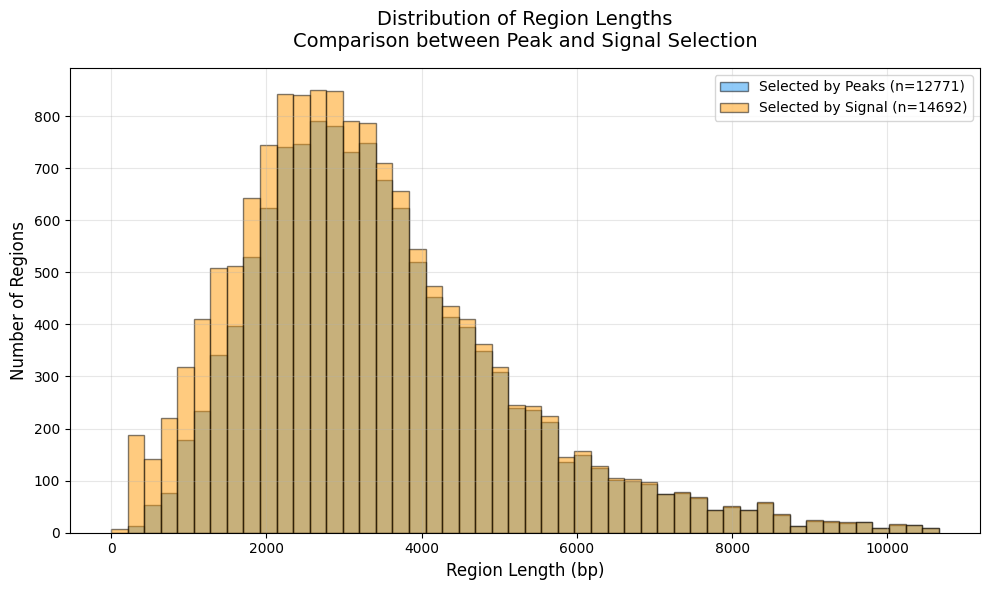

In [90]:
plot_region_length_comparison(both_df_by_peaks, both_df_by_signal, region_length_col='region_length')

In [91]:
both_df_sorted_by_region_length_signal = both_df_by_signal.sort_values(by='region_length', ascending=False)
both_df_sorted_by_region_length_signal.head()

,chr,start,end,exo_signal,endo_signal,enrichment,pvalue,binding_type,binding_type_by_peaks,significant,exo_replicates_with_signal,endo_replicates_with_signal,exo_replicate_signals,endo_replicate_signals,region_length,cpg_length,cpg_score,cpg_name,exo_replicates_with_peaks,endo_replicates_with_peaks,exo_peak_scores_by_rep,endo_peak_scores_by_rep,region_start,region_end
12242,chr7,45717703,45718318,31.806518,36.448500,0.872643,1.0,both,both,False,3,3,"33.03791549623241,34.05267709520635,28.32896270983769","46.28682986409696,31.1067631678273,31.95190802204576",21582,615,CpG:,933,3,2,6.44844;4.51086;8.79106,4.89628;11.8479,45700675,45722257
12240,chr7,45713359,45713615,33.748239,41.276677,0.817610,0.4,both,endo_only,False,3,3,"35.39147714133252,35.71502853770806,30.138211381089384","50.575669412973255,38.321259069942876,34.93310139458494",19164,256,CpG:,933,0,3,NaN,6.8612;6.68945;11.8479,45700675,45719839
12237,chr7,45704790,45705154,33.748239,41.276677,0.817610,0.4,both,both,False,3,3,"35.39147714133252,35.71502853770806,30.138211381089384","50.575669412973255,38.321259069942876,34.93310139458494",19164,364,CpG:,933,3,3,11.8131;10.0331;11.1781,28.2728;12.7485;11.8479,45700675,45719839
12239,chr7,45706651,45707060,33.748239,41.276677,0.817610,0.4,both,both,False,3,3,"35.39147714133252,35.71502853770806,30.138211381089384","50.575669412973255,38.321259069942876,34.93310139458494",19164,409,CpG:,933,2,3,3.31782;10.0331,4.31391;12.7485;11.8479,45700675,45719839
12238,chr7,45705454,45705704,33.748239,41.276677,0.817610,0.4,both,both,False,3,3,"35.39147714133252,35.71502853770806,30.138211381089384","50.575669412973255,38.321259069942876,34.93310139458494",19164,250,CpG:,933,3,3,11.8131;10.0331;11.1781,28.2728;12.7485;11.8479,45700675,45719839


In [92]:
both_df_sorted_by_region_length_peaks = both_df_by_peaks.sort_values(by='region_length', ascending=False)
both_df_sorted_by_region_length_peaks.head()

,chr,start,end,exo_signal,endo_signal,enrichment,pvalue,binding_type,binding_type_by_peaks,significant,exo_replicates_with_signal,endo_replicates_with_signal,exo_replicate_signals,endo_replicate_signals,region_length,cpg_length,cpg_score,cpg_name,exo_replicates_with_peaks,endo_replicates_with_peaks,exo_peak_scores_by_rep,endo_peak_scores_by_rep,region_start,region_end
12242,chr7,45717703,45718318,31.806518,36.448500,0.872643,1.0,both,both,False,3,3,"33.03791549623241,34.05267709520635,28.32896270983769","46.28682986409696,31.1067631678273,31.95190802204576",21582,615,CpG:,933,3,2,6.44844;4.51086;8.79106,4.89628;11.8479,45700675,45722257
12239,chr7,45706651,45707060,33.748239,41.276677,0.817610,0.4,both,both,False,3,3,"35.39147714133252,35.71502853770806,30.138211381089384","50.575669412973255,38.321259069942876,34.93310139458494",19164,409,CpG:,933,2,3,3.31782;10.0331,4.31391;12.7485;11.8479,45700675,45719839
12241,chr7,45714976,45715370,33.748239,41.276677,0.817610,0.4,both,both,False,3,3,"35.39147714133252,35.71502853770806,30.138211381089384","50.575669412973255,38.321259069942876,34.93310139458494",19164,394,CpG:,933,3,3,13.0324;9.20095;9.97968,16.9373;6.68945;11.8479,45700675,45719839
12237,chr7,45704790,45705154,33.748239,41.276677,0.817610,0.4,both,both,False,3,3,"35.39147714133252,35.71502853770806,30.138211381089384","50.575669412973255,38.321259069942876,34.93310139458494",19164,364,CpG:,933,3,3,11.8131;10.0331;11.1781,28.2728;12.7485;11.8479,45700675,45719839
12238,chr7,45705454,45705704,33.748239,41.276677,0.817610,0.4,both,both,False,3,3,"35.39147714133252,35.71502853770806,30.138211381089384","50.575669412973255,38.321259069942876,34.93310139458494",19164,250,CpG:,933,3,3,11.8131;10.0331;11.1781,28.2728;12.7485;11.8479,45700675,45719839


In [93]:
print_outlier_groups(both_df_sorted_by_region_length_peaks, "peaks")


First 5 outliers selected by peaks:
chr7:45,717,703-45,718,318                        enrichment: 0.8726427185530012
chr7:45,706,651-45,707,060                        enrichment: 0.8176103741579192
chr7:45,714,976-45,715,370                        enrichment: 0.8176103741579192
chr7:45,704,790-45,705,154                        enrichment: 0.8176103741579192
chr7:45,705,454-45,705,704                        enrichment: 0.8176103741579192

Middle 5 outliers selected by peaks:
chr1:131,096,809-131,097,847                      enrichment: 0.8923261927344872
chr18:60,560,588-60,561,141                       enrichment: 1.887059260533126
chr17:72,836,216-72,836,475                       enrichment: 0.8703053754814976
chr7:88,278,003-88,278,275                        enrichment: 3.908148824958369
chr1:118,459,277-118,459,794                      enrichment: 2.339874192436039

Last 5 outliers selected by peaks:
chr11:77,930,886-77,931,638                       enrichment: 0.5273139815599809
c

In [94]:
print_outlier_groups(both_df_sorted_by_region_length_signal, "signal")


First 5 outliers selected by signal:
chr7:45,717,703-45,718,318                        enrichment: 0.8726427185530012
chr7:45,713,359-45,713,615                        enrichment: 0.8176103741579192
chr7:45,704,790-45,705,154                        enrichment: 0.8176103741579192
chr7:45,706,651-45,707,060                        enrichment: 0.8176103741579192
chr7:45,705,454-45,705,704                        enrichment: 0.8176103741579192

Middle 5 outliers selected by signal:
chr7:43,562,155-43,562,388                        enrichment: 2.7178488895791326
chr16:4,939,045-4,939,501                         enrichment: 0.9042810482431743
chr8:78,508,509-78,509,789                        enrichment: 2.304786303791146
chr2:165,387,949-165,388,334                      enrichment: 1.823585528820585
chr13:35,906,090-35,906,319                       enrichment: 1.660723093415924

Last 5 outliers selected by signal:
chr19:37,018,415-37,018,686                       enrichment: 0.788722777172836

### CpG length - defined by the CpG coordinates

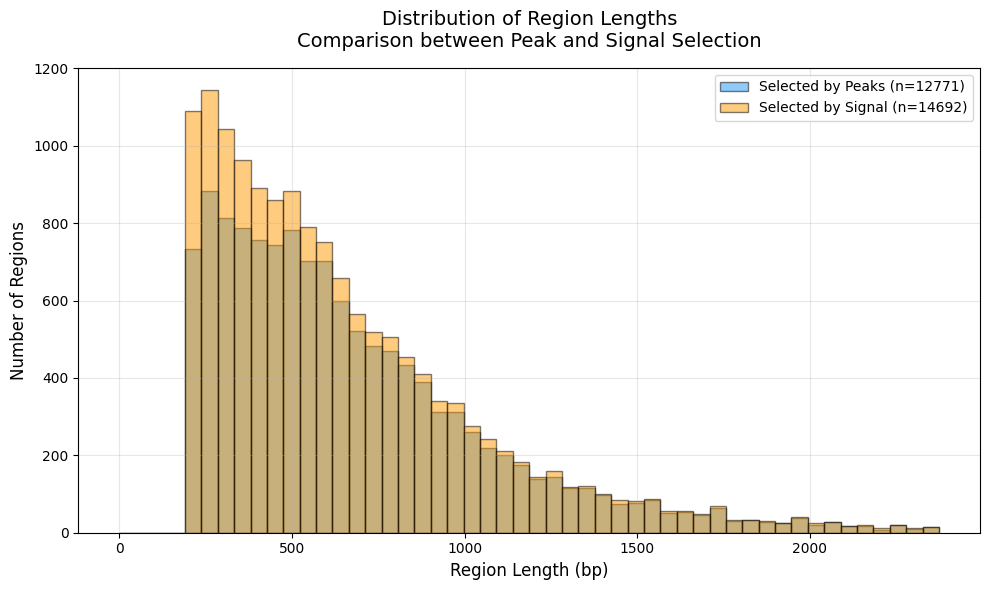

In [95]:
plot_region_length_comparison(both_df_by_peaks, both_df_by_signal, region_length_col='cpg_length')

In [96]:
both_df_sorted_by_cpg_length_peaks = both_df_by_peaks.sort_values(by='cpg_length', ascending=False)
both_df_sorted_by_cpg_length_peaks.head()
print_outlier_groups(both_df_sorted_by_cpg_length_peaks, "peaks")


First 5 outliers selected by peaks:
chr8:92,355,697-92,360,826                        enrichment: 1.631518113187943
chr5:33,430,439-33,435,552                        enrichment: 2.037166655415914
chrX:12,086,982-12,092,060                        enrichment: 1.1126597809526018
chrX:12,076,861-12,081,915                        enrichment: 1.3044556383340078
chr17:34,118,396-34,122,981                       enrichment: 1.0309508872445343

Middle 5 outliers selected by peaks:
chr17:56,079,292-56,079,874                       enrichment: 0.5632486550657011
chr13:21,981,189-21,981,771                       enrichment: 0.7151289694796025
chr2:122,348,507-122,349,089                      enrichment: 0.9001816498540903
chr1:79,761,251-79,761,833                        enrichment: 0.9907414000487064
chr12:9,029,921-9,030,503                         enrichment: 1.1268111996642411

Last 5 outliers selected by peaks:
chr2:36,049,236-36,049,437                        enrichment: 1.1264993370417515


In [97]:
both_df_sorted_by_cpg_length_signal = both_df_by_signal.sort_values(by='cpg_length', ascending=False)
both_df_sorted_by_cpg_length_signal.head()
print_outlier_groups(both_df_sorted_by_cpg_length_signal, "signal")


First 5 outliers selected by signal:
chr8:92,355,697-92,360,826                        enrichment: 1.631518113187943
chr5:33,430,439-33,435,552                        enrichment: 2.037166655415914
chrX:12,086,982-12,092,060                        enrichment: 1.1126597809526018
chrX:12,076,861-12,081,915                        enrichment: 1.3044556383340078
chr17:34,118,396-34,122,981                       enrichment: 1.0309508872445343

Middle 5 outliers selected by signal:
chr13:105,293,968-105,294,519                     enrichment: 1.6817733854766412
chr13:63,567,807-63,568,358                       enrichment: 1.0397178757141217
chr18:6,764,956-6,765,507                         enrichment: 1.0401739859986492
chr18:67,245,174-67,245,725                       enrichment: 1.0456420559352002
chr18:23,803,759-23,804,310                       enrichment: 1.8454018132073169

Last 5 outliers selected by signal:
chr6:83,572,297-83,572,498                        enrichment: 0.85905356189932

# Exo only

In [98]:
exo_only_df_by_peaks.head()

,chr,start,end,exo_signal,endo_signal,enrichment,pvalue,binding_type,binding_type_by_peaks,significant,exo_replicates_with_signal,endo_replicates_with_signal,exo_replicate_signals,endo_replicate_signals,region_length,cpg_length,cpg_score,cpg_name,exo_replicates_with_peaks,endo_replicates_with_peaks,exo_peak_scores_by_rep,endo_peak_scores_by_rep,region_start,region_end
48,chr1,17091517,17091971,18.636133,0.0,inf,1.0,exo_only,exo_only,False,2,0,"18.06756362446978,0.0,37.84083460916364","0.0,0.0,0.0",1467,454,CpG:,715,2,0,5.67863;7.84621,NaN,17090590,17092057
14929,chrX,168122986,168123301,17.661884,0.0,inf,1.0,exo_only,exo_only,False,2,0,"29.36382449578945,23.621828120347168,0.0","0.0,0.0,0.0",974,315,CpG:,1867,2,0,3.28488;4.05905,NaN,168122898,168123872
4535,chr15,50869482,50869839,11.308360,0.0,inf,1.0,exo_only,exo_only,False,2,0,"31.51041352066528,2.4146678776853414,0.0","0.0,0.0,0.0",1188,357,CpG:,973,1,0,6.06184,NaN,50868579,50869767
3173,chr12,85698178,85698533,7.930034,0.0,inf,1.0,exo_only,exo_only,False,2,0,"23.038968674295496,0.0,0.7511327927036119","0.0,0.0,0.0",686,355,CpG:,1238,1,0,3.12533,NaN,85698057,85698743
12831,chr7,143107028,143107765,30.080851,0.0,inf,1.0,exo_only,exo_only,False,2,0,"89.00711970108406,1.2354339578820834,0.0","0.0,0.0,0.0",367,737,CpG:,1676,1,0,6.25924,NaN,143106761,143107128


In [99]:
# Generate summary statistics for numeric columns, ignoring inf values
# Replace inf values with NaN before calculating statistics
numeric_cols = ['exo_signal', 'endo_signal', 'enrichment', 'region_length', 'cpg_length', 'pvalue']

stats_df = exo_only_df_by_peaks[numeric_cols].replace([np.inf, -np.inf], np.nan).describe()
print("Exo only - by peaks, size:", len(exo_only_df_by_peaks))
stats_df

Exo only - by peaks, size: 1442


,exo_signal,endo_signal,enrichment,region_length,cpg_length,pvalue
count,1442.000000,1442.000000,1276.000000,1442.000000,1442.000000,1442.000000
mean,18.294065,5.881999,18.517347,1813.934119,509.357836,0.606241
std,10.656279,8.019820,120.842847,1412.967735,360.456031,0.333187
min,0.000000,0.000000,0.000000,209.000000,201.000000,0.100000
25%,11.501982,1.029825,1.853785,804.250000,263.000000,0.333333
50%,15.975097,3.903786,3.354254,1468.500000,388.000000,0.666667
75%,22.523661,7.974897,7.970808,2440.000000,614.750000,1.000000
max,128.163503,99.897367,2992.085991,11110.000000,2785.000000,1.000000


In [100]:
stats_df = exo_only_df_by_signal[numeric_cols].replace([np.inf, -np.inf], np.nan).describe()
print("Exo only - by signal, size:", len(exo_only_df_by_signal))
stats_df

Exo only - by signal, size: 168


,exo_signal,endo_signal,enrichment,region_length,cpg_length,pvalue
count,168.000000,168.0,0.0,168.000000,168.000000,168.0
mean,16.856540,0.0,NaN,598.744048,501.857143,1.0
std,10.064422,0.0,NaN,436.188307,337.976212,0.0
min,0.031509,0.0,NaN,211.000000,202.000000,1.0
25%,10.044903,0.0,NaN,269.750000,270.750000,1.0
50%,14.058128,0.0,NaN,385.500000,371.500000,1.0
75%,21.674362,0.0,NaN,850.000000,603.250000,1.0
max,52.088128,0.0,NaN,2340.000000,2096.000000,1.0


In [101]:
print_across_distribution(exo_only_df_by_peaks, selection_type="peaks")


First 5 elements selected by peaks:
chr1:17,091,517-17,091,971                        enrichment: inf
chrX:168,122,986-168,123,301                      enrichment: inf
chr15:50,869,482-50,869,839                       enrichment: inf
chr12:85,698,178-85,698,533                       enrichment: inf
chr7:143,107,028-143,107,765                      enrichment: inf

Middle 5 elements selected by peaks:
chrX:152,144,159-152,145,127                      enrichment: 4.042438230871287
chr2:117,342,646-117,343,063                      enrichment: 4.035421156008061
chr10:61,273,127-61,273,655                       enrichment: 4.018870342450048
chr7:25,627,348-25,627,687                        enrichment: 4.014452629673685
chrX:36,329,941-36,330,273                        enrichment: 4.014252605000413

Last 5 elements selected by peaks:
chr17:87,133,914-87,134,157                       enrichment: 0.2467263310234858
chr13:45,078,550-45,079,118                       enrichment: 0.23507412578066

In [102]:
print_across_distribution(exo_only_df_by_signal, selection_type="signal")


First 5 elements selected by signal:
chr1:17,091,517-17,091,971                        enrichment: inf
chrX:168,122,986-168,123,301                      enrichment: inf
chr15:50,869,482-50,869,839                       enrichment: inf
chr12:85,698,178-85,698,533                       enrichment: inf
chr7:143,107,028-143,107,765                      enrichment: inf

Middle 5 elements selected by signal:
chr9:98,601,375-98,601,757                        enrichment: inf
chr4:128,767,041-128,767,520                      enrichment: inf
chr11:9,150,400-9,150,646                         enrichment: inf
chr15:103,827,185-103,827,395                     enrichment: inf
chr9:123,678,266-123,678,959                      enrichment: inf

Last 5 elements selected by signal:
chr6:77,243,659-77,244,825                        enrichment: inf
chr4:155,360,977-155,362,087                      enrichment: inf
chr14:69,174,640-69,175,155                       enrichment: inf
chr6:6,879,318-6,879,580    

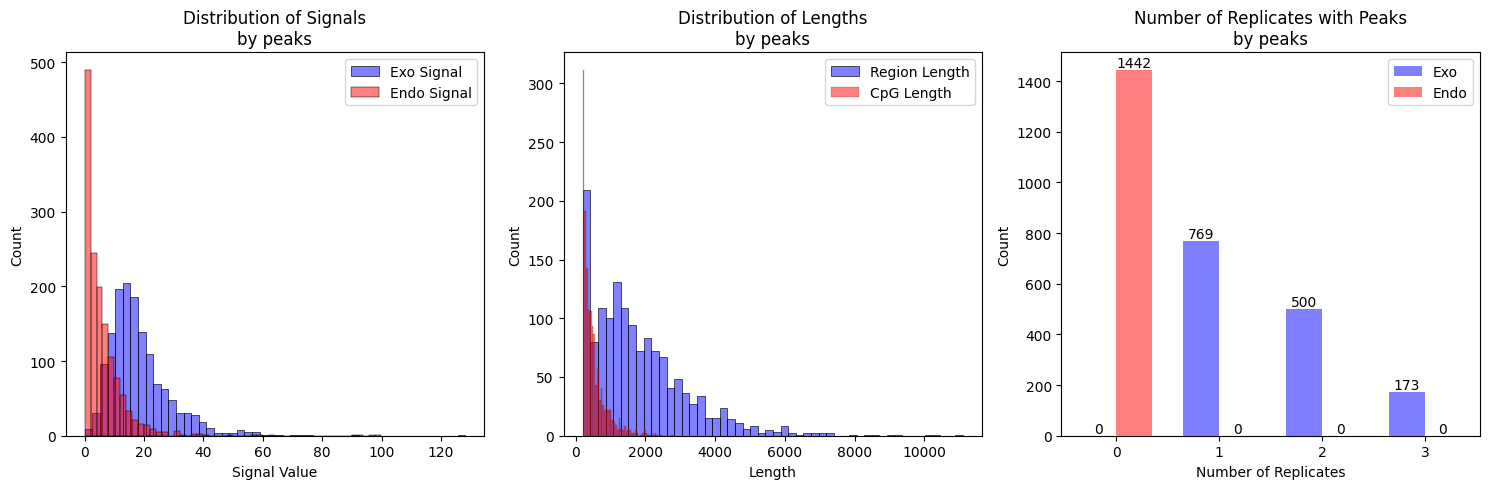

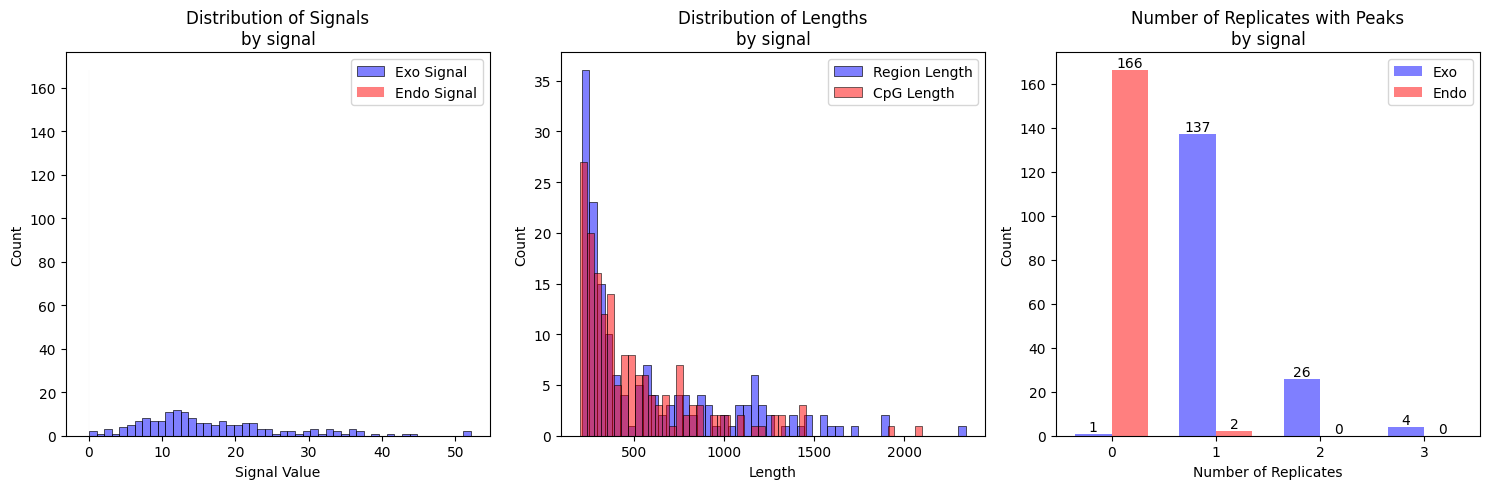

In [103]:
plot_exo_only_distributions(exo_only_df_by_peaks, title="by peaks")
plot_exo_only_distributions(exo_only_df_by_signal, title="by signal")

# Endo only

In [104]:
endo_only_df_by_peaks.head()

,chr,start,end,exo_signal,endo_signal,enrichment,pvalue,binding_type,binding_type_by_peaks,significant,exo_replicates_with_signal,endo_replicates_with_signal,exo_replicate_signals,endo_replicate_signals,region_length,cpg_length,cpg_score,cpg_name,exo_replicates_with_peaks,endo_replicates_with_peaks,exo_peak_scores_by_rep,endo_peak_scores_by_rep,region_start,region_end
1077,chr10,69269942,69270276,1.957780,0.000000,inf,1.0,exo_only,endo_only,False,1,0,"5.873341150143567,0.0,0.0","0.0,0.0,0.0",238,334,CpG:,1113,0,1,NaN,5.10203,69270185,69270423
12756,chr7,137198500,137198811,1.556473,0.023400,66.516878,1.0,both,endo_only,False,1,1,"4.669419034531242,0.0,0.0","0.07019901092638049,0.0,0.0",912,311,CpG:,1631,0,1,NaN,2.06063,137198350,137199262
14784,chrX,101695812,101697996,0.609943,0.046761,13.043734,1.0,both,endo_only,False,1,1,"0.0,1.8298284444283313,0.0","0.0,0.0,0.14028409440217054",1016,2184,CpG:,1360,0,1,NaN,7.07709,101695953,101696969
11611,chr6,125285873,125286114,11.308203,1.042549,10.846692,0.4,both,endo_only,False,3,2,"17.800002716167555,15.736094541807432,0.3885108452874261","2.8155746475425927,0.0,0.3120709187275655",925,241,CpG:,1540,0,1,NaN,4.6307,125285653,125286578
2953,chr12,49383077,49385808,43.275288,5.311279,8.147809,0.5,both,endo_only,False,3,1,"50.50962022778697,22.390619521388498,56.925624510349095","0.0,0.0,15.933837041112517",713,2731,CpG:,961,0,1,NaN,6.26102,49382414,49383127


In [105]:
# Generate summary statistics for numeric columns, ignoring inf values
# Replace inf values with NaN before calculating statistics
numeric_cols = ['exo_signal', 'endo_signal', 'enrichment', 'region_length', 'cpg_length', 'pvalue']

stats_df = endo_only_df_by_peaks[numeric_cols].replace([np.inf, -np.inf], np.nan).describe()
print("endo only - by peaks, size:", len(endo_only_df_by_peaks))
stats_df

endo only - by peaks, size: 726


,exo_signal,endo_signal,enrichment,region_length,cpg_length,pvalue
count,726.000000,726.000000,725.000000,726.000000,726.000000,726.000000
mean,7.592775,14.695621,0.708153,1780.589532,430.596419,0.716391
std,9.374253,11.040200,2.620370,1661.419947,305.742147,0.299219
min,0.000000,0.000000,0.000000,192.000000,201.000000,0.100000
25%,1.198812,8.376491,0.113962,748.750000,253.250000,0.400000
50%,4.602216,12.346499,0.415291,1329.000000,334.000000,0.800000
75%,10.352684,17.693863,0.852984,2274.750000,483.000000,1.000000
max,66.989505,100.928316,66.516878,19164.000000,3089.000000,1.000000


In [106]:
stats_df = endo_only_df_by_signal[numeric_cols].replace([np.inf, -np.inf], np.nan).describe()
print("endo only - by signal, size:", len(endo_only_df_by_signal))
stats_df

endo only - by signal, size: 79


,exo_signal,endo_signal,enrichment,region_length,cpg_length,pvalue
count,79.0,79.000000,79.0,79.000000,79.000000,79.0
mean,0.0,13.780765,0.0,550.848101,497.202532,1.0
std,0.0,12.120960,0.0,361.807644,349.941291,0.0
min,0.0,0.853623,0.0,192.000000,205.000000,1.0
25%,0.0,7.146949,0.0,272.500000,285.500000,1.0
50%,0.0,11.788319,0.0,390.000000,364.000000,1.0
75%,0.0,16.635990,0.0,737.000000,521.500000,1.0
max,0.0,97.139428,0.0,1814.000000,1736.000000,1.0


In [107]:
print_across_distribution(endo_only_df_by_peaks, selection_type="peaks")


First 5 elements selected by peaks:
chr10:69,269,942-69,270,276                       enrichment: inf
chr7:137,198,500-137,198,811                      enrichment: 66.51687784359501
chrX:101,695,812-101,697,996                      enrichment: 13.043734232496275
chr6:125,285,873-125,286,114                      enrichment: 10.846691987455234
chr12:49,383,077-49,385,808                       enrichment: 8.147809214098753

Middle 5 elements selected by peaks:
chr5:137,189,323-137,189,646                      enrichment: 0.4215242390456707
chr10:128,459,651-128,459,860                     enrichment: 0.4192436624703525
chr13:95,604,059-95,604,766                       enrichment: 0.4152914143768948
chr6:86,388,668-86,388,878                        enrichment: 0.4150480263397219
chr1:3,531,624-3,531,843                          enrichment: 0.4136159348282142

Last 5 elements selected by peaks:
chr17:6,256,745-6,257,192                         enrichment: 0.0
chr9:118,559,594-118,559,833  

In [108]:
print_across_distribution(endo_only_df_by_signal, selection_type="signal")


First 5 elements selected by signal:
chr3:54,810,972-54,811,405                        enrichment: 0.0
chr12:56,521,093-56,521,319                       enrichment: 0.0
chr5:147,270,137-147,270,628                      enrichment: 0.0
chr15:25,364,175-25,364,865                       enrichment: 0.0
chr4:147,738,466-147,739,154                      enrichment: 0.0

Middle 5 elements selected by signal:
chr8:69,399,389-69,399,768                        enrichment: 0.0
chr11:76,601,278-76,601,611                       enrichment: 0.0
chr4:117,729,384-117,729,589                      enrichment: 0.0
chr7:126,847,586-126,847,941                      enrichment: 0.0
chr7:123,982,572-123,983,871                      enrichment: 0.0

Last 5 elements selected by signal:
chr17:6,256,745-6,257,192                         enrichment: 0.0
chr9:118,559,594-118,559,833                      enrichment: 0.0
chr6:3,763,576-3,763,862                          enrichment: 0.0
chrX:139,610,568-139,611,192

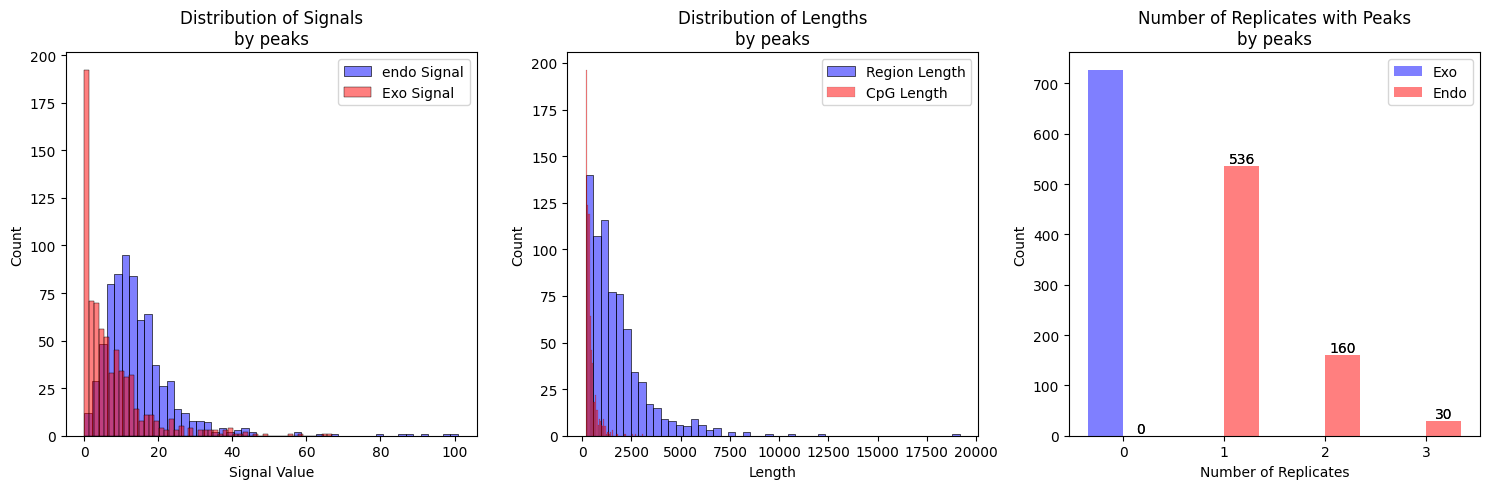

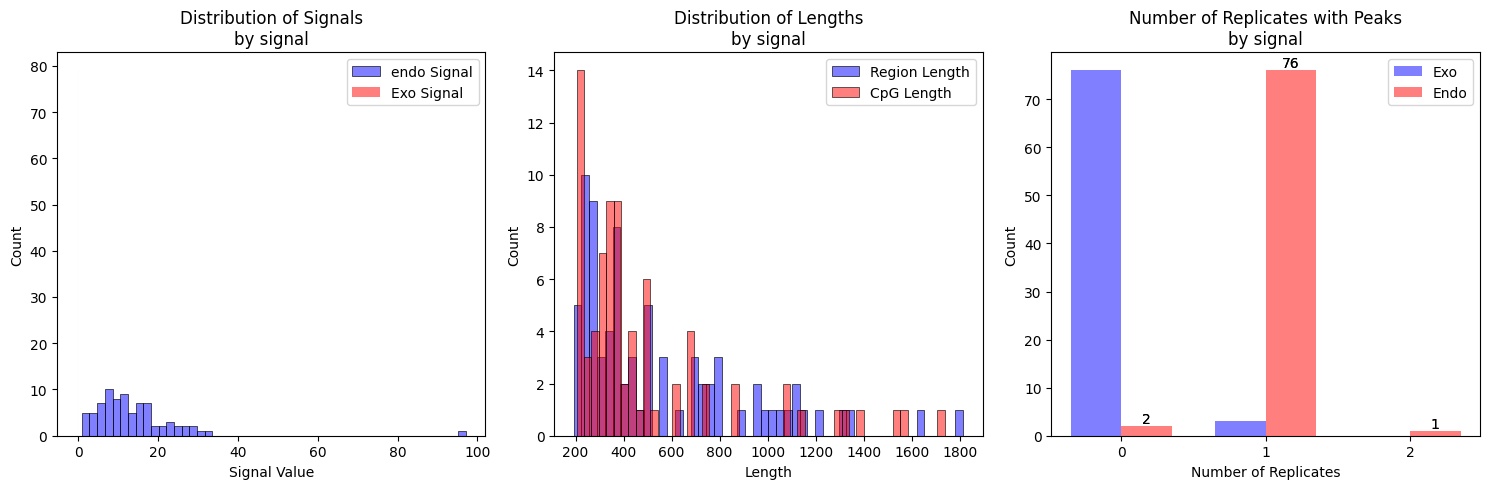

In [109]:
plot_endo_only_distributions(endo_only_df_by_peaks, title="by peaks")
plot_endo_only_distributions(endo_only_df_by_signal, title="by signal")

# Create output files

## UP in Exo

In [110]:
up_enriched_signal_1 = both_df_by_signal[(both_df_by_signal['enrichment'] > 1) & (both_df_by_signal['enrichment'] < range_max_signal)].copy()
up_enriched_signal_1_5 = both_df_by_signal[(both_df_by_signal['enrichment'] > 1.5) & (both_df_by_signal['enrichment'] < range_max_signal)].copy()    
up_enriched_signal_2 = both_df_by_signal[(both_df_by_signal['enrichment'] > 2) & (both_df_by_signal['enrichment'] < range_max_signal)].copy()
up_enriched_peaks_1 = both_df_by_peaks[(both_df_by_peaks['enrichment'] > 1) & (both_df_by_peaks['enrichment'] < range_max_peaks)].copy()
up_enriched_peaks_1_5 = both_df_by_peaks[(both_df_by_peaks['enrichment'] > 1.5) & (both_df_by_peaks['enrichment'] < range_max_peaks)].copy()    
up_enriched_peaks_2 = both_df_by_peaks[(both_df_by_peaks['enrichment'] > 2) & (both_df_by_peaks['enrichment'] < range_max_peaks)].copy()

In [111]:
print("up_enriched_signal_1.shape:",   up_enriched_signal_1.shape)
print("up_enriched_signal_1_5.shape:", up_enriched_signal_1_5.shape)
print("up_enriched_signal_2.shape:",   up_enriched_signal_2.shape)
print("up_enriched_peaks_1.shape:",    up_enriched_peaks_1.shape)
print("up_enriched_peaks_1_5.shape:",  up_enriched_peaks_1_5.shape)
print("up_enriched_peaks_2.shape:",    up_enriched_peaks_2.shape)

up_enriched_signal_1.shape: (10806, 24)
up_enriched_signal_1_5.shape: (6336, 24)
up_enriched_signal_2.shape: (3513, 24)
up_enriched_peaks_1.shape: (9237, 24)
up_enriched_peaks_1_5.shape: (4992, 24)
up_enriched_peaks_2.shape: (2347, 24)


## UP in Endo

In [112]:
down_enriched_signal_1 = both_df_by_signal[(both_df_by_signal['enrichment'] < 1.0 ) & (both_df_by_signal['enrichment'] < range_max_signal)].copy()
down_enriched_signal_08 = both_df_by_signal[(both_df_by_signal['enrichment'] < 0.8 ) & (both_df_by_signal['enrichment'] < range_max_signal)].copy()
down_enriched_signal_05 = both_df_by_signal[(both_df_by_signal['enrichment'] < 0.5 ) & (both_df_by_signal['enrichment'] < range_max_signal)].copy()
down_enriched_peaks_1 = both_df_by_peaks[(both_df_by_peaks['enrichment'] < 1.0) & (both_df_by_peaks['enrichment'] < range_max_peaks)].copy()
down_enriched_peaks_08 = both_df_by_peaks[(both_df_by_peaks['enrichment'] < 0.8) & (both_df_by_peaks['enrichment'] < range_max_peaks)].copy()
down_enriched_peaks_05 = both_df_by_peaks[(both_df_by_peaks['enrichment'] < 0.5) & (both_df_by_peaks['enrichment'] < range_max_peaks)].copy()


In [113]:
print("down_enriched_signal_1.shape:",  down_enriched_signal_1.shape)
print("down_enriched_signal_08.shape:", down_enriched_signal_08.shape)
print("down_enriched_signal_05.shape:", down_enriched_signal_05.shape)
print("down_enriched_peaks_1.shape:",   down_enriched_peaks_1.shape)
print("down_enriched_peaks_08.shape:",  down_enriched_peaks_08.shape)
print("down_enriched_peaks_05.shape:",  down_enriched_peaks_05.shape)

down_enriched_signal_1.shape: (3855, 24)
down_enriched_signal_08.shape: (2174, 24)
down_enriched_signal_05.shape: (677, 24)
down_enriched_peaks_1.shape: (3274, 24)
down_enriched_peaks_08.shape: (1689, 24)
down_enriched_peaks_05.shape: (340, 24)


## Save output files

In [114]:
up_enriched_signal_1.to_csv(f'{OUTPUT_LISTS_PATH}/up_enriched_signal_1.csv', index=False)
up_enriched_signal_1_5.to_csv(f'{OUTPUT_LISTS_PATH}/up_enriched_signal_1_5.csv', index=False)
up_enriched_signal_2.to_csv(f'{OUTPUT_LISTS_PATH}/up_enriched_signal_2.csv', index=False)
up_enriched_peaks_1.to_csv(f'{OUTPUT_LISTS_PATH}/up_enriched_peaks_1.csv', index=False)
up_enriched_peaks_1_5.to_csv(f'{OUTPUT_LISTS_PATH}/up_enriched_peaks_1_5.csv', index=False)
up_enriched_peaks_2.to_csv(f'{OUTPUT_LISTS_PATH}/up_enriched_peaks_2.csv', index=False)

down_enriched_signal_1.to_csv(f'{OUTPUT_LISTS_PATH}/down_enriched_signal_1.csv', index=False)
down_enriched_signal_08.to_csv(f'{OUTPUT_LISTS_PATH}/down_enriched_signal_08.csv', index=False)
down_enriched_signal_05.to_csv(f'{OUTPUT_LISTS_PATH}/down_enriched_signal_05.csv', index=False)
down_enriched_peaks_1.to_csv(f'{OUTPUT_LISTS_PATH}/down_enriched_peaks_1.csv', index=False)
down_enriched_peaks_08.to_csv(f'{OUTPUT_LISTS_PATH}/down_enriched_peaks_08.csv', index=False)
down_enriched_peaks_05.to_csv(f'{OUTPUT_LISTS_PATH}/down_enriched_peaks_05.csv', index=False)

exo_only_df_by_signal.to_csv(f'{OUTPUT_LISTS_PATH}/exo_only_df_by_signal.csv', index=False)
endo_only_df_by_signal.to_csv(f'{OUTPUT_LISTS_PATH}/endo_only_df_by_signal.csv', index=False)
exo_only_df_by_peaks.to_csv(f'{OUTPUT_LISTS_PATH}/exo_only_df_by_peaks.csv', index=False)
endo_only_df_by_peaks.to_csv(f'{OUTPUT_LISTS_PATH}/endo_only_df_by_peaks.csv', index=False)

# Exo min expression filtering

In [115]:
up_enriched_signal_1_exo_over_20 = up_enriched_signal_1[up_enriched_signal_1['exo_signal'] >= 20]
up_enriched_signal_1_5_exo_over_20 = up_enriched_signal_1_5[up_enriched_signal_1_5['exo_signal'] >= 20]
up_enriched_signal_2_exo_over_20 = up_enriched_signal_2[up_enriched_signal_2['exo_signal'] >= 20]
up_enriched_peaks_1_exo_over_20 = up_enriched_peaks_1[up_enriched_peaks_1['exo_signal'] >= 20]
up_enriched_peaks_1_5_exo_over_20 = up_enriched_peaks_1_5[up_enriched_peaks_1_5['exo_signal'] >= 20]
up_enriched_peaks_2_exo_over_20 = up_enriched_peaks_2[up_enriched_peaks_2['exo_signal'] >= 20]

down_enriched_signal_1_exo_over_20 = down_enriched_signal_1[down_enriched_signal_1['exo_signal'] >= 20]
down_enriched_signal_08_exo_over_20 = down_enriched_signal_08[down_enriched_signal_08['exo_signal'] >= 20]
down_enriched_signal_05_exo_over_20 = down_enriched_signal_05[down_enriched_signal_05['exo_signal'] >= 20]
down_enriched_peaks_1_exo_over_20 = down_enriched_peaks_1[down_enriched_peaks_1['exo_signal'] >= 20]
down_enriched_peaks_08_exo_over_20 = down_enriched_peaks_08[down_enriched_peaks_08['exo_signal'] >= 20]
down_enriched_peaks_05_exo_over_20 = down_enriched_peaks_05[down_enriched_peaks_05['exo_signal'] >= 20]

exo_only_df_by_signal_exo_over_20 = exo_only_df_by_signal[exo_only_df_by_signal['exo_signal'] >= 20]
endo_only_df_by_signal_exo_over_20 = endo_only_df_by_signal[endo_only_df_by_signal['exo_signal'] >= 20]
exo_only_df_by_peaks_exo_over_20 = exo_only_df_by_peaks[exo_only_df_by_peaks['exo_signal'] >= 20]
endo_only_df_by_peaks_exo_over_20 = endo_only_df_by_peaks[endo_only_df_by_peaks['exo_signal'] >= 20]


up_enriched_signal_1_exo_over_20.to_csv(f'{OUTPUT_LISTS_PATH}/up_enriched_signal_1_exo_over_20.csv', index=False)
up_enriched_signal_1_5_exo_over_20.to_csv(f'{OUTPUT_LISTS_PATH}/up_enriched_signal_1_5_exo_over_20.csv', index=False)
up_enriched_signal_2_exo_over_20.to_csv(f'{OUTPUT_LISTS_PATH}/up_enriched_signal_2_exo_over_20.csv', index=False)
up_enriched_peaks_1_exo_over_20.to_csv(f'{OUTPUT_LISTS_PATH}/up_enriched_peaks_1_exo_over_20.csv', index=False)
up_enriched_peaks_1_5_exo_over_20.to_csv(f'{OUTPUT_LISTS_PATH}/up_enriched_peaks_1_5_exo_over_20.csv', index=False)
up_enriched_peaks_2_exo_over_20.to_csv(f'{OUTPUT_LISTS_PATH}/up_enriched_peaks_2_exo_over_20.csv', index=False)

down_enriched_signal_1_exo_over_20.to_csv(f'{OUTPUT_LISTS_PATH}/down_enriched_signal_1_exo_over_20.csv', index=False)
down_enriched_signal_08_exo_over_20.to_csv(f'{OUTPUT_LISTS_PATH}/down_enriched_signal_08_exo_over_20.csv', index=False)
down_enriched_signal_05_exo_over_20.to_csv(f'{OUTPUT_LISTS_PATH}/down_enriched_signal_05_exo_over_20.csv', index=False)
down_enriched_peaks_1_exo_over_20.to_csv(f'{OUTPUT_LISTS_PATH}/down_enriched_peaks_1_exo_over_20.csv', index=False)
down_enriched_peaks_08_exo_over_20.to_csv(f'{OUTPUT_LISTS_PATH}/down_enriched_peaks_08_exo_over_20.csv', index=False)
down_enriched_peaks_05_exo_over_20.to_csv(f'{OUTPUT_LISTS_PATH}/down_enriched_peaks_05_exo_over_20.csv', index=False)

exo_only_df_by_signal_exo_over_20.to_csv(f'{OUTPUT_LISTS_PATH}/exo_only_df_by_signal_exo_over_20.csv', index=False)
endo_only_df_by_signal_exo_over_20.to_csv(f'{OUTPUT_LISTS_PATH}/endo_only_df_by_signal_exo_over_20.csv', index=False)
exo_only_df_by_peaks_exo_over_20.to_csv(f'{OUTPUT_LISTS_PATH}/exo_only_df_by_peaks_exo_over_20.csv', index=False)
endo_only_df_by_peaks_exo_over_20.to_csv(f'{OUTPUT_LISTS_PATH}/endo_only_df_by_peaks_exo_over_20.csv', index=False)